# IHC Attribution API Example Usage

**API URL: https://api.advanced-attribution.com**


We have 4 API endpoints:
- **/train-ihc-parameter**: 
    - the Initializer and Closer membership functions are trained on a provided set of CJs
    - the parameter are returned
    - the parameter are stored in a  database for use in later computations, with the keys:
        - account: identifier for potential different platforms
        - market: identifier for different markets
        - conv_code: identifier for different conversion types
- **/compute-ihc-with-stored-parameter**:
    - compute the IHC attribution based on stored parameter
- **/compute-ihc**:
    - compute the IHC attribution based on parameter provided in the request
- **/get-stored-ihc-parameter**:
    - return all stored ihc parameter

In [1]:
import json
import requests
import pprint

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.style.use('ggplot')
%matplotlib inline

def linear_membership(t,a=2.0, x_offset=0.125):
    x_shifted = t-x_offset
    y_shifted = max(0, (x_shifted/(a-x_offset) ) )
    return min(y_shifted, 1)

## Configuration

Here, the user needs to put the API Key received from https://service.advanced-attribution.com/

In [2]:
api_url = 'https://api.advanced-attribution.com'
api_key = '{api_key}'

## Define which IHC Parameters to retrieve (version 1)
account = 'ihc-webservice-test-account'
conv_code = 'ihc-webservice-test-conv_code'
market = 'INT'

## Customer Journeys

Here, we read in example customer journeys. You can choose between a single customer journey (default) (*example_single_cj_ihc_computation.txt*) for seeing how IHC attribution works for a single case or a set of nine customer journeys (*example_cjs_ihc_computation.txt*) in case you want to see how to use the endpoint to request IHC results for multiple customer journeys at the same time.  
Please refer to the example customer journeys as the format guideline for estimating IHC Parameters. We require the customer_journeys object to be a list of conversions, whereas each conversion is a dictionary with the keys being unique identifers of the session and the values containing following information:
- **'event_datetime'** (str: timestamp of the session in format '%Y-%m-%d %H:%M:%S', e.g. '2020-06-22 16:42:11')
- **'conversion_id'** (str: identifier of the conversion event that this belongs to; each session belongs to one conversion and multiple sessions belonging to one conversion make up one customer journey)
- **'initializer_valid'** (boolean: if the session should be able to receive 'Initializer' Attribution scores in the given customer journey)
- **'holder_valid'** (boolean: if the session should be able to receive 'Holder' Attribution scores in the given customer journey)
- **'closer_valid'** (boolean: if the session should be able to receive 'Closer' Attribution scores in the given customer journey; generally the last session in each customer journey should be 'Closer Valid')
- **'redistribute_attribution_results'** (boolean: if the sessions' attribution scores should be redistributed to other sessions in the customer journey, this usually makes sense if one wants to see IHC scores while ignoring channels that can not be influenced directly (e.g. 'Direct' traffic))
- **'impression_interaction'** (boolean: if the session is an impression interaction)

In [3]:
with open('./example_data/example_single_cj_ihc_computation.txt') as json_file:
    customer_journeys = json.load(json_file)

---

# Get IHC Scores for Example Customer Journeys

## Version 1: Use previously stored IHC Parameter 
After running the estimation Notebook, we have stored the estimated IHC Parameter for you. You are able to retrieve them for IHC Computation when passing the matching 'conversion_metadata' information here.
(Notebook: ihc_webservice_parameter_estimation)

In [4]:
## Create Request Body
body = {
    'customer_journeys': customer_journeys,
    'conversion_metadata': {
        'account': account,
        'market': market,
        'conv_code': conv_code
    }
}

In [5]:
response = requests.post(
    api_url + '/compute-ihc-with-stored-parameter',
    data=json.dumps(body), 
    headers = {
        'Content-Type': 'application/json',
        'x-api-key': api_key
}
) 
ihc_results = json.loads(response.content)
pprint.pprint( ihc_results )

[{'session_id_122': {'closer_fraction_core': 0.0,
                     'closer_fraction_redistributed': 0.0,
                     'conversion_id': 'conversion_id_7',
                     'first_interaction_attribution': 1.0,
                     'holder_fraction_core': 0.0,
                     'holder_fraction_redistributed': 0.0,
                     'initializer_fraction_core': 0.790708,
                     'initializer_fraction_redistributed': 0.790708,
                     'last_interaction_attribution': 0.0,
                     'session_number': 1,
                     'session_type': 'site'},
  'session_id_123': {'closer_fraction_core': 0.0,
                     'closer_fraction_redistributed': 0.0,
                     'conversion_id': 'conversion_id_7',
                     'first_interaction_attribution': 0.0,
                     'holder_fraction_core': 0.17006,
                     'holder_fraction_redistributed': 0.0,
                     'initializer_fraction_core': 0.0

## Put Results into Pandas Dataframe

We are now parsing the IHC Results into a Pandas Dataframe that you can work with.

In [6]:
df_attribution_results = []
for conv in ihc_results:
    df_ihc_results = pd.DataFrame.from_dict(conv, orient='index')
    df_attribution_results.append(df_ihc_results)
df_attribution_results = pd.concat(df_attribution_results)
df_attribution_results = df_attribution_results.reset_index()
df_attribution_results = df_attribution_results.rename(columns = {
    "index": "session_id"
})

In [7]:
display(df_attribution_results)

,session_id,session_number,session_type,conversion_id,first_interaction_attribution,last_interaction_attribution,initializer_fraction_core,holder_fraction_core,closer_fraction_core,initializer_fraction_redistributed,holder_fraction_redistributed,closer_fraction_redistributed
0,session_id_122,1,site,conversion_id_7,1.0,0.0,0.790708,0.00000,0.00000,0.790708,0.000000,0.0
1,session_id_123,2,site,conversion_id_7,0.0,0.0,0.000000,0.17006,0.00000,0.000000,0.000000,0.0
2,session_id_124,3,site,conversion_id_7,0.0,0.0,0.022610,0.16520,0.00000,0.209292,0.928768,0.0
3,session_id_125,4,site,conversion_id_7,0.0,0.0,0.000000,0.00000,0.00000,0.000000,0.000000,0.0
4,session_id_126,5,site,conversion_id_7,0.0,0.0,0.070691,0.15486,0.00000,0.000000,0.000000,0.0
5,session_id_127,6,site,conversion_id_7,0.0,0.0,0.067291,0.15559,0.00000,0.000000,0.000000,0.0
6,session_id_128,7,site,conversion_id_7,0.0,0.0,0.017470,0.16630,0.00000,0.000000,0.000000,0.0
7,session_id_129,8,site,conversion_id_7,0.0,0.0,0.000000,0.01267,0.32635,0.000000,0.071232,1.0
8,session_id_130,9,site,conversion_id_7,0.0,0.0,0.031230,0.00526,0.33416,0.000000,0.000000,0.0
9,session_id_131,10,site,conversion_id_7,0.0,0.0,0.000000,0.17006,0.00000,0.000000,0.000000,0.0


----

## Version 2: Use Custom IHC Parameters

Instead of using the estimated IHC Parameters from the other notebook, you can also define them manually to see their affect on the resulting IHC scores.

### Define IHC Parameters

In [8]:
ihc_membership_parameters = {
    'membership_functions': {
        'initializer': {
            'start_function_time_days': 1.5,
            'end_function_time_days': 8,
            'function': 'linear',
            'function_parameter': {}
        },
        'closer': {
            'start_function_time_days': 0.0,
            'end_function_time_days': 5,
            'function': 'linear',
            'function_parameter': {}
        },
        'impression_impact': {
            'max_impact_factor': 1.0,
            'start_function_time_hours': 1,
            'end_function_time_hours': 24,
            'function': 'linear',
            'function_parameter' : {}
        }
    },
    ## This section allows to change the behaviour for redistribution/adjusted IHC
    'redistribution_setting' : {
              'impressions_receive_redistribution': False,
              'strict_redistribution': True,
              'attribution_threshold_strict': 0.05,
              'redistribute_initializer_only_to_preceding_sessions': True
    },

}

## Visualize Initializer and Closer Membership Functions

In this step we visualize the just defined IHC Membership Functions

### Initializer

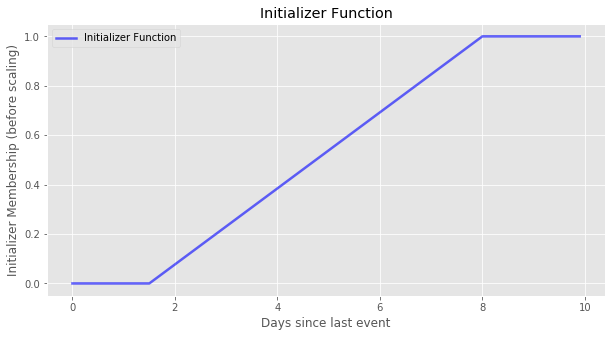

In [9]:
day_range = np.arange(0, ihc_membership_parameters['membership_functions']['initializer']['end_function_time_days']+2.0, 0.1)

fig = plt.figure(figsize=(10,5))
plt.title('Initializer Function')
plt.plot(day_range, [ linear_membership(t, 
                                        a=ihc_membership_parameters['membership_functions']['initializer']['end_function_time_days'], 
                                        x_offset=ihc_membership_parameters['membership_functions']['initializer']['start_function_time_days']
                                       ) for t in day_range], 
         label='Initializer Function', alpha=0.6, linewidth=2.5, color='blue')
plt.legend()
plt.xlabel('Days since last event')
plt.ylabel('Initializer Membership (before scaling)')

plt.show()

### Closer

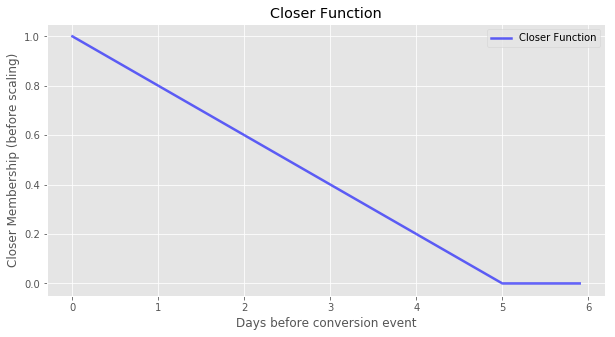

In [10]:
day_range = np.arange(0, ihc_membership_parameters['membership_functions']['closer']['end_function_time_days']+1.0, 0.1)

fig = plt.figure(figsize=(10,5))
plt.title('Closer Function')
plt.plot(day_range, [ 1.0 - linear_membership(t, 
                                        a=ihc_membership_parameters['membership_functions']['closer']['end_function_time_days'], 
                                        x_offset=ihc_membership_parameters['membership_functions']['closer']['start_function_time_days']
                                       ) for t in day_range],
         label='Closer Function', alpha=0.6, linewidth=2.5, color='blue')
plt.legend()
plt.xlabel('Days before conversion event')
plt.ylabel('Closer Membership (before scaling)')

plt.show()

## Create Request Body and Run IHC Computation

In [11]:
## Create Request Body
body = {
    'customer_journeys': customer_journeys,
    'ihc_parameter': ihc_membership_parameters
}

In [12]:
response = requests.post(
    api_url + '/compute-ihc', 
    data=json.dumps(body), 
    headers= {
        'Content-Type': 'application/json',    
        'x-api-key': api_key
    }
) 
ihc_results = json.loads(response.content)
pprint.pprint( ihc_results )

[{'session_id_122': {'closer_fraction_core': 0.0,
                     'closer_fraction_redistributed': 0.0,
                     'conversion_id': 'conversion_id_7',
                     'first_interaction_attribution': 1.0,
                     'holder_fraction_core': 0.0,
                     'holder_fraction_redistributed': 0.0,
                     'initializer_fraction_core': 0.795928,
                     'initializer_fraction_redistributed': 0.795928,
                     'last_interaction_attribution': 0.0,
                     'session_number': 1,
                     'session_type': 'site'},
  'session_id_123': {'closer_fraction_core': 0.0,
                     'closer_fraction_redistributed': 0.0,
                     'conversion_id': 'conversion_id_7',
                     'first_interaction_attribution': 0.0,
                     'holder_fraction_core': 0.148451,
                     'holder_fraction_redistributed': 0.148451,
                     'initializer_fraction_core

## Put Results into Pandas Dataframe
We are now parsing the IHC Results into a Pandas Dataframe that you can work with.

In [13]:
df_attribution_results = []
for conv in ihc_results:
    df_ihc_results = pd.DataFrame.from_dict(conv, orient='index')
    df_attribution_results.append(df_ihc_results)
df_attribution_results = pd.concat(df_attribution_results)
df_attribution_results = df_attribution_results.reset_index()
df_attribution_results = df_attribution_results.rename(columns = {
    "index": "session_id"
})

In [14]:
display(df_attribution_results)

,session_id,session_number,session_type,conversion_id,first_interaction_attribution,last_interaction_attribution,initializer_fraction_core,holder_fraction_core,closer_fraction_core,initializer_fraction_redistributed,holder_fraction_redistributed,closer_fraction_redistributed
0,session_id_122,1,site,conversion_id_7,1.0,0.0,0.795928,0.000000,0.00000,0.795928,0.000000,0.00000
1,session_id_123,2,site,conversion_id_7,0.0,0.0,0.000000,0.148451,0.00000,0.000000,0.148451,0.00000
2,session_id_124,3,site,conversion_id_7,0.0,0.0,0.000000,0.148451,0.00000,0.000000,0.148451,0.00000
3,session_id_125,4,site,conversion_id_7,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000
4,session_id_126,5,site,conversion_id_7,0.0,0.0,0.107131,0.128471,0.00000,0.107131,0.128471,0.00000
5,session_id_127,6,site,conversion_id_7,0.0,0.0,0.096941,0.130371,0.00000,0.096941,0.130371,0.00000
6,session_id_128,7,site,conversion_id_7,0.0,0.0,0.000000,0.148451,0.00000,0.000000,0.148451,0.00000
7,session_id_129,8,site,conversion_id_7,0.0,0.0,0.000000,0.097871,0.22020,0.000000,0.097871,0.22020
8,session_id_130,9,site,conversion_id_7,0.0,0.0,0.000000,0.049480,0.34658,0.000000,0.049480,0.34658
9,session_id_131,10,site,conversion_id_7,0.0,0.0,0.000000,0.148451,0.00000,0.000000,0.148451,0.00000
